In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
# import seaborn as sns
import numpy as np
# import torch
# import torch.distributions.categorical
import scipy
import scipy.stats
import math


In [2]:
def adjust_qr(rx, rp, rz):
    
    rz_new, rp_new = np.unique(rx, return_counts=True)
    rp_new = rp_new * rp[0]
    #rz_new= np.arange(0, len(rp_new), 1)
    
    return rx, rp_new, rz_new

In [3]:
def VaR(z, p, lim):
    var = 0
    cum_p = 0
    for j, atom in enumerate(p):
        cum_p += atom
        if cum_p>= lim:
            var = z[j]
            break
    return var

def CVaR (z, p, var, lim):
    cvar = var
    expected_c = 0 
    for i, j in enumerate(p):
        if p[i] > 0:
            expected_c += j * max(0, z[i]-var)
    cvar+= 1/(1- alpha) * expected_c
    return cvar

def variance(z, p):
    average = np.average(z, weights=p)
    variance = np.average((z-average)**2, weights=p)
    return variance

def weighted_mean(z,p):
    return np.average(z, weights=p)

def prob_threshold(z, p, thresh):
    cum_p = 0
    for j, atom in enumerate(p):        
        if z[j]>= thresh:
            cum_p += atom
            
    return cum_p

In [4]:
def l2 (u_values, v_values, u_weights=None, v_weights=None, debug=False):
    u_values = np.asarray(u_values, dtype=float)
    v_values = np.asarray(v_values, dtype=float)
    u_weights = np.asarray(u_weights, dtype=float)
    v_weights = np.asarray(v_weights, dtype=float)
    
    u_sorter = np.argsort(u_values)
    v_sorter = np.argsort(v_values)

    all_values = np.concatenate((u_values, v_values))
    all_values.sort(kind='mergesort')

    # Compute the differences between pairs of successive values of u and v.
    deltas = np.diff(all_values)

    # Get the respective positions of the values of u and v among the values of
    # both distributions.
    u_cdf_indices = u_values[u_sorter].searchsorted(all_values[:-1], 'right')
    v_cdf_indices = v_values[v_sorter].searchsorted(all_values[:-1], 'right')

    # Calculate the CDFs of u and v using their weights
    u_sorted_cumweights = np.concatenate(([0],np.cumsum(u_weights[u_sorter])))
    u_cdf = u_sorted_cumweights[u_cdf_indices] / u_sorted_cumweights[-1]

    v_sorted_cumweights = np.concatenate(([0],np.cumsum(v_weights[v_sorter])))
    v_cdf = v_sorted_cumweights[v_cdf_indices] / v_sorted_cumweights[-1]
    
    if debug:
        print("delta", deltas)
        print("cdf u:", u_cdf)
        print("cdf v:", v_cdf)
        print("square cdf u - cdf v", np.square(u_cdf - v_cdf))
        print("square diff * delta", np.multiply(np.square(u_cdf - v_cdf), deltas))
        print("sum( (square diff) *delta))", np.sum(np.multiply(np.square(u_cdf - v_cdf), deltas)))
    return np.sqrt(np.sum(np.multiply(np.square(u_cdf - v_cdf), deltas)))


## Graphs

##### DTMC

In [5]:
def dtmc_compute(idx, apdx, show_graph=True, debug=True, print_metrics=False):
    if debug:
        print('Reading file: '+file_path+experiment_name+'/'+experiment_name+'_distr_dtmc_'+alg_type+'_'+rep_type+apdx+'.csv')
    dist = pd.read_csv(file_path+experiment_name+'/'+experiment_name+'_distr_dtmc_'+alg_type+'_'+rep_type+apdx+'.csv')
    #dist.head(10)
    rx = dist['r'].to_numpy()
    rp = dist['p'].to_numpy()
    n = np.max(np.where(rp > 1e-20))
    rx = rx[0:n+1]
    rp = rp[0:n+1]
    # z = z[0:n+1]
    if debug:
        print(n)
        print(np.sum(rp), np.allclose(np.sum(rp), 1))
        print("max p:", np.max(rp))
    if show_graph:
        distr = scipy.stats.rv_discrete(values=(rx, rp))
        # h = plt.bar(rx, rp, alpha=0.5)
        fig = plt.figure(figsize=fig_size)
        if (xmax-xmin)>400:
            h = plt.bar(rx, distr.pmf(rx), width=1, alpha=0.5, label='PDF')
        else:
            h = plt.bar(rx, distr.pmf(rx), alpha=0.5, label='PDF')
        kernel = scipy.stats.gaussian_kde(rx, weights=rp)
        range = np.arange(0, n, 0.1)
        plt.plot(range, kernel(range), label='Smoothed PDF')
        plt.xlim([xmin,xmax])
        plt.ylim([0,ymax])

        plt.legend(loc='upper right', fontsize=graphsize-10)
        plt.tick_params(axis='both', which='major', labelsize=graphsize-10)
        plt.ticklabel_format(axis='both')
        plt.xlabel('Cost', fontsize=graphsize)
        plt.ylabel('Probability', fontsize=graphsize)
        plt.grid(b=True, which='major', color='#666666', linestyle='-', linewidth=0.25)
        plt.tight_layout()

        plt.show()
    # plt.fill_between(range, kernel(range))

    if save_graphs:
        print('Saving to:'+file_path+experiment_name+'/'+experiment_name+'_distr_dtmc_'+alg_type+'_'+rep_type+apdx+".png")
        fig.savefig(file_path+experiment_name+'/'+experiment_name+'_distr_dtmc_'+alg_type+'_'+rep_type+apdx+".png", transparent=True, dpi=400)


    var_dtmc = VaR(rx, rp, alpha)
    if debug or print_metrics:
        print(weighted_mean(rx, rp),",",variance(rx, rp),",",var_dtmc,",", CVaR(rx, rp, var_dtmc, alpha),",",prob_threshold(rx, rp, thresh))
    return rx,rp, np.array([weighted_mean(rx, rp), variance(rx, rp), var_dtmc, CVaR(rx, rp, var_dtmc, alpha), prob_threshold(rx, rp, thresh)])

##### Expected Value Iteration

In [6]:
def exp_compute(idx, apdx, show_graph=True, debug=True, print_metrics=False):
    if debug:
        print('Reading file: '+file_path+experiment_name+'/'+experiment_name+'_distr_exp_'+rep_type+apdx+'.csv')
    dist = pd.read_csv(file_path+experiment_name+'/'+experiment_name+'_distr_exp_'+rep_type+apdx+'.csv')
    #dist.head(10)
    rx_e = dist['r'].to_numpy()
    rp_e = dist['p'].to_numpy()
    z_e = dist['z'].to_numpy()
    if 'qr' in rep_type:
        if debug:
            print('converting distribution from qr')
        rx_e, rp_e, z_e = adjust_qr(rx_e, rp_e, z_e)
        # print(len(rx_e), rx_e)
        # print(len(rp_e), rp_e)
        # print(len(z_e), z_e)

    n = np.max(np.where(rp_e > 1e-8))
    rx_e = rx_e[0:n+1]
    rp_e = rp_e[0:n+1]
    z_e = z_e[0:n+1]
    
    if debug:
        print(len(dist.index))
        print(np.sum(rp_e), np.allclose(np.sum(rp_e), 1))
        print("max p:", np.max(rp_e))
    
    if show_graph:
        distr_e = scipy.stats.rv_discrete(values=(z_e, rp_e))
        # h = plt.bar(rx_e, rp_e, alpha=0.5)
        fig = plt.figure(figsize=fig_size)
        h = plt.bar(z_e, rp_e, alpha=0.5, color='g', label='PDF')
        kernel = scipy.stats.gaussian_kde(z_e, weights=rp_e)
        if 'qr' in rep_type:
            range = z_e
        else:
            range = np.arange(0, z_e[-1]+z_e[1], z_e[1])

        plt.plot(range, kernel(z_e), color='g', label='Smoothed PDF')
        plt.xlim([xmin,xmax])
        plt.ylim([0,ymax])

        plt.legend(loc='upper right', fontsize=graphsize-10)
        plt.tick_params(axis='both', which='major', labelsize=graphsize-10)
        plt.ticklabel_format(axis='both')
        plt.xlabel('Cost', fontsize=graphsize)
        plt.ylabel('Probability', fontsize=graphsize)
        plt.grid(b=True, which='major', color='#666666', linestyle='-', linewidth=0.25)
        plt.tight_layout()
        plt.show()
    # plt.fill_between(range, kernel(range))

        if save_graphs:
            print('Saving to:'+file_path+experiment_name+'/'+experiment_name+'_distr_exp_'+rep_type+apdx+".png")
            fig.savefig(file_path+experiment_name+'/'+experiment_name+'_distr_exp_'+rep_type+apdx+".png", transparent=True, dpi=400)
    
    var_exp = VaR(z_e, rp_e, alpha)
    if debug or print_metrics:
        print(f"{weighted_mean(z_e, rp_e)},{variance(z_e, rp_e)},{var_exp},{CVaR(z_e, rp_e, var_exp, alpha)},{prob_threshold(z_e, rp_e, thresh)}")
    return z_e, rp_e, np.array([weighted_mean(z_e, rp_e), variance(z_e, rp_e), var_exp, CVaR(z_e, rp_e, var_exp, alpha), prob_threshold(z_e, rp_e, thresh)])

##### CVaR

In [7]:
def cvar_compute(idx, apdx, show_graph=True, debug=True, print_metrics=False):
    if debug:
        print('Reading file: '+file_path+experiment_name+'/'+experiment_name+'_distr_cvar_'+rep_type+apdx+'.csv')
    dist = pd.read_csv(file_path+experiment_name+'/'+experiment_name+'_distr_cvar_'+rep_type+apdx+'.csv')
    #dist.head(10)
    rx_c = dist['r'].to_numpy()
    rp_c = dist['p'].to_numpy()
    z_c = dist['z'].to_numpy()
    if 'qr' in rep_type:
        if debug:
            print('converting distribution from qr')
        rx_c, rp_c, z_c = adjust_qr(rx_c, rp_c, z_c)
    n = np.max(np.where(rp_c > 1e-6))
    rx_c = rx_c[0:n+1]
    rp_c = rp_c[0:n+1]
    z_c = z_c[0:n+1]
    if debug:
        print(n)
        print(np.sum(rp_c), np.allclose(np.sum(rp_c), 1))
        print("max p:", np.max(rp_c))
    
    if show_graph:
        distr_c = scipy.stats.rv_discrete(values=(z_c, rp_c))
        # h = plt.bar(rx_c, rp_c, alpha=0.5)
        fig=plt.figure(figsize=fig_size)
        h = plt.bar(z_c, rp_c, alpha=0.5, color='g', label='PDF')
        kernel = scipy.stats.gaussian_kde(z_c, weights=rp_c)
        if 'qr' in rep_type:
            range = z_c
        else:
            range = np.arange(0, z_c[-1]+z_c[1], z_c[1]) 
        plt.plot(range, kernel(range), color='g', label='Smoothed PDF')
        plt.xlim([xmin,xmax])
        plt.ylim([0,ymax])

        plt.legend(loc='upper right', fontsize=graphsize-10)
        plt.tick_params(axis='both', which='major', labelsize=graphsize-10)
        plt.ticklabel_format(axis='both')
        plt.xlabel('Cost', fontsize=graphsize)
        plt.ylabel('Probability', fontsize=graphsize)
        plt.grid(b=True, which='major', color='#666666', linestyle='-', linewidth=0.25)
        plt.tight_layout()
        plt.show()
        # plt.fill_between(range, kernel(range))

        if save_graphs:
            print('Saving to:'+file_path+experiment_name+'/'+experiment_name+'_distr_cvar_'+rep_type+apdx+".png")
            fig.savefig(file_path+experiment_name+'/'+experiment_name+'_distr_cvar_'+rep_type+apdx+".png", transparent=True, dpi=400)
        
    var_cvar = VaR(z_c, rp_c, alpha)
    if debug or print_metrics:
        print(f"{weighted_mean(z_c, rp_c)},{variance(z_c, rp_c)},{var_cvar},{CVaR(z_c, rp_c, var_cvar, alpha)},{prob_threshold(z_c, rp_c, thresh)}")
    return z_c, rp_c, np.array([weighted_mean(z_c, rp_c), variance(z_c, rp_c), var_cvar, CVaR(z_c, rp_c, var_cvar, alpha), prob_threshold(z_c, rp_c, thresh)])

#### Setup

In [129]:
alpha=0.8 # 0.7 except for ds_treasure and betting_game -> 0.8
thresh=500 #600
xmax = 805
xmin=-5
ymax=0.05
fig_size= (12,6)

In [133]:
# Graph Formating
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': False
})
graphsize = 35
file_path = 'tests/experiments/'
experiment_name='grid_150_3535'
apdx =  [''] #['_10', '_25', '_50', '_75', '_100'] # [''] # ['_10', '_25', '_50', '_75', '_100','_500', '_1000', '_5000']
alg_type = 'cvar' # Used only for the DTMC graph
rep_type = 'c51'
save_graphs = False
num_metrics = 5 # exp val, variance, var, cvar, prob>thresh, 

In [134]:
metrics_dtmc = np.zeros([len(apdx), num_metrics])
metrics_e = np.zeros([len(apdx), num_metrics])
metrics_c = np.zeros([len(apdx), num_metrics])
print_metrics=True

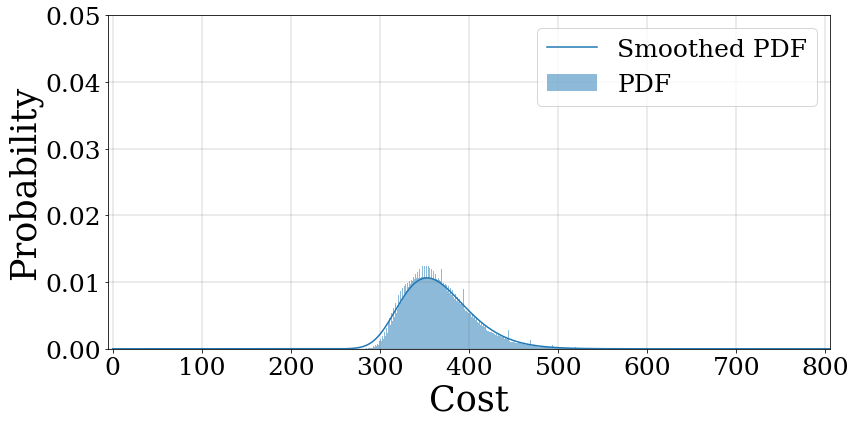

365.96648847637823,1377.4266778891872,395,422.8403488346582,0.0031063572200079447


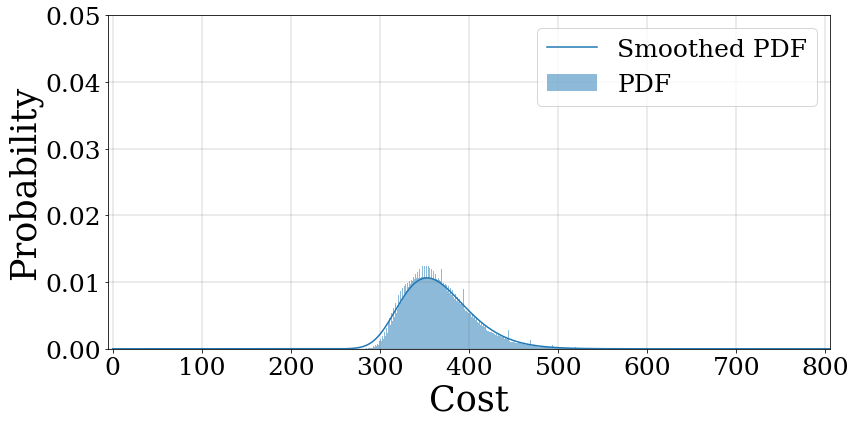

365.96648847637823,1377.4266778891872,395,422.8403488346582,0.0031063572200079447
---d-


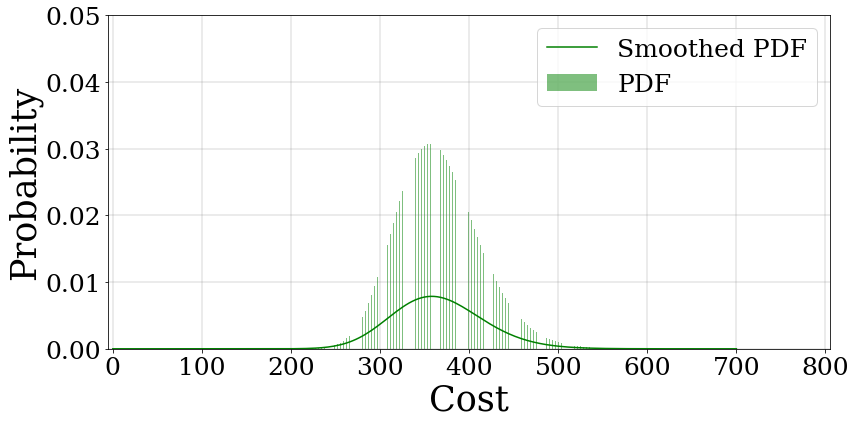

366.0328935752592,2211.9352960938204,402.5,435.381318517502,0.007388650707185436


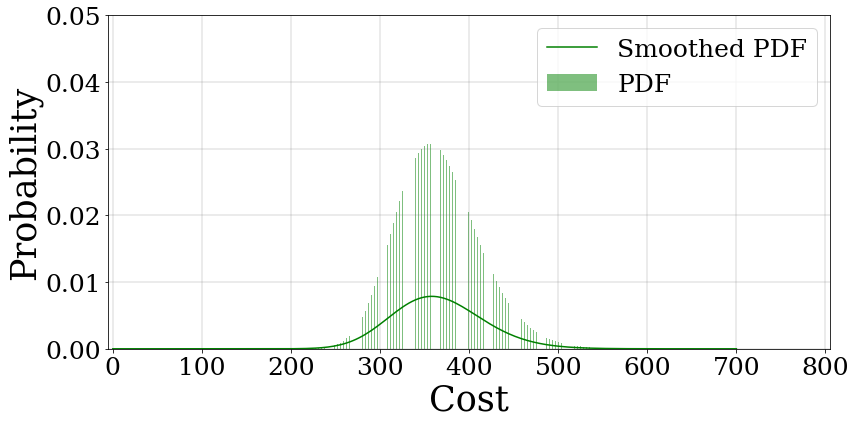

366.0328935752592,2211.935296093821,402.5,435.381318517502,0.007388650707185434


In [140]:
algs=['exp','cvar'] #['vi', 'exp', 'cvar']
appendix  = '_p_0.17_w_26'
for idx, alg_type in enumerate(algs):
    _,_,_ = dtmc_compute(idx, appendix, show_graph=True, debug=False, print_metrics=True)
print('---d-')
_,_,_ = exp_compute(idx, appendix, show_graph=True, debug=False, print_metrics=True)
_,_,_ = cvar_compute(idx, appendix, show_graph=True, debug=False, print_metrics=True)

##### Running varying atoms.

In [39]:
apdx = ['_1','_10', '_25', '_50', '_75', '_100']
apdx = ['_1','_10', '_25', '_50', '_75', '_100','_500', '_1000', '_5000']
rep_type = 'qr'
metrics_dtmc = np.zeros([len(apdx), num_metrics])
metrics_e = np.zeros([len(apdx), num_metrics])
metrics_c = np.zeros([len(apdx), num_metrics])
print_metrics=True

In [40]:
for idx, apd in enumerate(apdx):
    if 'c51' in rep_type and idx > 5:
        continue
    _,_, metrics_e[idx] = exp_compute(idx, apd, show_graph=False, debug=False, print_metrics=print_metrics)

3000.0,0.0,3000.0,3000.0,1.0
599.0,2127067.4,122.0,1753.3333333333333,0.2
311.43999999999994,912764.9663999999,124.0,798.6666666666666,0.28
217.44,465822.4064000001,124.0,483.8666666666667,0.3
185.33333333333334,311378.9155555556,128.0,374.66666666666663,0.27999999999999997
169.90000000000003,235760.03000000003,128.0,323.8666666666667,0.29000000000000004
123.408,1323.3295360000002,130.0,167.7733333333333,0.28800000000000014
124.092,1402.2075360000001,132.0,169.77333333333334,0.29200000000000015
123.94639999999998,1373.0563270399998,132.0,169.18533333333335,0.2898


In [41]:
alg_type = 'exp'
for idx, apd in enumerate(apdx):
    if 'c51' in rep_type and idx > 5:
        continue
    _,_, metrics_dtmc[idx] = dtmc_compute(idx, apd, show_graph=False, debug=False, print_metrics=print_metrics)

1709.1655584546759 , 1042.773375844702 , 1726 , 1746.325331900845 , 0.9999999999999999
125.3095645121544 , 1306.6712998520384 , 134 , 170.02096913468034 , 0.27210854239282584
124.05848276039184 , 1433.4881775684728 , 130 , 169.60020186171334 , 0.2893227861329188
124.05848276039184 , 1433.4881775684728 , 130 , 169.60020186171334 , 0.2893227861329188
124.05848276039184 , 1433.4881775684728 , 130 , 169.60020186171334 , 0.2893227861329188
124.05848276039184 , 1433.4881775684728 , 130 , 169.60020186171334 , 0.2893227861329188
124.05848276039184 , 1433.4881775684728 , 130 , 169.60020186171334 , 0.2893227861329188
124.05848276039184 , 1433.4881775684728 , 130 , 169.60020186171334 , 0.2893227861329188
124.05848276039184 , 1433.4881775684728 , 130 , 169.60020186171334 , 0.2893227861329188


In [25]:
if 'c51' in rep_type:
    apdx =['_0', '_10', '_25', '_50', '_75', '_100']
for idx, apd in enumerate(apdx):
    if idx > 5:
        continue
    _,_, metrics_c[idx] = cvar_compute(idx, apd, show_graph=False, debug=False, print_metrics=print_metrics)

123.79896539525377,1396.8856672588877,132.0,169.3389589510523,0.27081091758820747
124.0489693745391,1483.6707125825749,132.0,170.17390088228638,0.2708161519660578
124.21055721108509,1467.1671551022773,132.0,170.23876136148456,0.27098503516816613
124.07170676543954,1481.3682014227759,132.0,170.18164019303447,0.27077202105616033
127.9784652375409,1224.6069840519033,132.0,170.27003025344987,0.2623528828947735
127.24897214985562,1272.241246407528,132.0,170.12891842904872,0.2601936481883726


In [27]:
alg_type = 'cvar'
for idx, apd in enumerate(apdx):
    if 'c51' in rep_type and idx > 5:
        continue
    _,_, metrics_dtmc[idx] = dtmc_compute(idx, apd, show_graph=False, debug=False, print_metrics=print_metrics)

124.05848276039183 , 1433.4881775684728 , 130 , 169.60020186171332 , 0.2893227861329188
124.05848276039183 , 1433.4881775684728 , 130 , 169.60020186171334 , 0.28932278613291873
124.21992153864062 , 1416.980528771671 , 132 , 169.68776504729414 , 0.288000791776813
124.08118004799813 , 1431.1780280265518 , 130 , 169.61709872051716 , 0.2893786305656874
127.98700517215742 , 1172.993198028758 , 132 , 169.5675120807067 , 0.2581405349180804
127.25767561301508 , 1220.9074265892682 , 132 , 169.39167762876653 , 0.25703937714140596


##### DTMC vs Dist VI metrics

In [42]:
distance = np.zeros([len(apdx)])
distance2 =np.zeros([len(apdx)])
apdx = ['_1','_10', '_25', '_50', '_75', '_100','_500', '_1000', '_5000']

alg_type = 'exp'
rep_types = [ 'qr']

if 'cvar' in alg_type:
    apdx = [el+'_va' for el in apdx]

for rep_type in rep_types:
    print(rep_type)
    for idx, apd in enumerate(apdx):
        
        if 'c51' in rep_type and idx > 5:
            continue
        rx, rp, metrics_dtmc[idx] = dtmc_compute(idx,  apd, show_graph=False, debug=False)

        if 'exp' in alg_type:
            rx_v, rp_v, metrics_e[idx] = exp_compute(idx, apd, show_graph=False, debug=False)
        else:
            rx_v, rp_v, metrics_c[idx] = cvar_compute(idx, apd, show_graph=False, debug=False)

        if 'c51' in rep_type:
            distance[idx] = l2(rx, rx_v, rp, rp_v, debug=False)

        elif 'qr' in rep_type:
            distance[idx] = scipy.stats.wasserstein_distance(rx, rx_v, rp, rp_v)
            distance2[idx] = l2(rx, rx_v, rp, rp_v, debug=False)
            
        print(distance[idx])

    if 'qr' in rep_type:
        print('----- l2-----')
        for idx in range(len(apdx)):
            print(distance2[idx])

qr
1290.8344415453246
479.8642477786243
192.6087468650953
96.43234863142362
64.15434304742445
48.17942884116957
0.6591207777615955
0.3887855692112141
0.22601226715913683
----- l2-----
35.67406196635674
6.904704583543752
2.7730516780291565
1.3907544129932043
0.9261858747890848
0.6955709874287795
0.04574864580179325
0.026628713620798945
0.015598091641303016


In [ ]:
distance = np.zeros([len(apdx)])

for idx, apd in enumerate(apdx):
    rx, rp, metrics_dtmc[idx] = dtmc_compute(idx,  apd, show_graph=False, debug=False)
    
    if 'exp' in alg_type:
        rx_v, rp_v, metrics_e[idx] = exp_compute(idx, apd, show_graph=False, debug=False)
    else:
        rx_v, rp_v, metrics_c[idx] = cvar_compute(idx, apd, show_graph=False, debug=False)
        
    if 'c51' in rep_type:
        distance[idx] = l2(rx, rx_v, rp, rp_v, debug=False)
        
    elif 'qr' in rep_type:
        distance[idx] = scipy.stats.wasserstein_distance(rx, rx_v, rp, rp_v)

In [ ]:
distance

array([2.52137285, 1.45146309, 0.41475579, 0.32884378, 0.49834999])

### Debugging

In [ ]:
z_c

NameError: name 'z_c' is not defined

In [ ]:
rx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171])

In [ ]:
rp_c

array([1.88055423e-16, 7.60895559e-15, 1.50388177e-13, 2.61631202e-09,
       4.82070682e-08, 4.29124819e-07, 1.14260387e-05, 1.35392735e-04,
       8.62333127e-04, 3.57049409e-03, 1.06640733e-02, 2.45131179e-02,
       4.53995809e-02, 7.02033476e-02, 9.33399063e-02, 1.09371364e-01,
       1.15297037e-01, 1.11208544e-01, 9.94855098e-02, 8.34460974e-02,
       6.62087336e-02, 5.00652333e-02, 3.63257103e-02, 2.54598770e-02,
       1.73604236e-02, 1.16086038e-02, 7.68069539e-03, 5.07799410e-03,
       3.38936227e-03, 2.30669090e-03, 1.61434067e-03, 1.16860713e-03,
       8.76800187e-04, 6.80239440e-04, 5.42139784e-04, 4.39709710e-04,
       3.59227749e-04, 2.92920757e-04, 2.36812923e-04, 1.89117036e-04,
       1.49041826e-04, 1.16020326e-04, 8.93473656e-05, 6.81337464e-05,
       5.14266000e-05, 3.83518624e-05, 2.81937469e-05, 2.03966969e-05,
       1.45213699e-05, 1.01959041e-05, 2.24271869e-05])

In [ ]:
rp

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.38412872e-02, 2.49143170e-02, 2.61600328e-02, 4.58423432e-02,
       5.89721882e-02, 5.55639097e-02, 6.84921979e-02, 7.49130658e-02,
       6.58677524e-02, 6.94185090e-02, 6.89302350e-02, 5.77841948e-02,
       5.56075158e-02, 5.17785836e-02, 4.19238502e-02, 3.79993686e-02,
       3.37980312e-02, 2.66537226e-02, 2.31513815e-02, 1.98974780e-02,
       1.53711130e-02, 1.29322555e-02, 1.08227751e-02, 8.22342432e-03,
       6.74923223e-03, 5.52963027e-03, 4.14489968e-03, 3.33504734e-03,
       2.68544700e-03, 1.99029537e-03, 1.57563973e-03, 1.25058743e-03,
      

In [ ]:
rp_c

array([1.88055423e-16, 7.60895559e-15, 1.50388177e-13, 2.61631202e-09,
       4.82070682e-08, 4.29124819e-07, 1.14260387e-05, 1.35392735e-04,
       8.62333127e-04, 3.57049409e-03, 1.06640733e-02, 2.45131179e-02,
       4.53995809e-02, 7.02033476e-02, 9.33399063e-02, 1.09371364e-01,
       1.15297037e-01, 1.11208544e-01, 9.94855098e-02, 8.34460974e-02,
       6.62087336e-02, 5.00652333e-02, 3.63257103e-02, 2.54598770e-02,
       1.73604236e-02, 1.16086038e-02, 7.68069539e-03, 5.07799410e-03,
       3.38936227e-03, 2.30669090e-03, 1.61434067e-03, 1.16860713e-03,
       8.76800187e-04, 6.80239440e-04, 5.42139784e-04, 4.39709710e-04,
       3.59227749e-04, 2.92920757e-04, 2.36812923e-04, 1.89117036e-04,
       1.49041826e-04, 1.16020326e-04, 8.93473656e-05, 6.81337464e-05,
       5.14266000e-05, 3.83518624e-05, 2.81937469e-05, 2.03966969e-05,
       1.45213699e-05, 1.01959041e-05, 2.24271869e-05])

## Statistics

In [ ]:
def W(p, u, v):
    u = np.sort(u)
    v = np.sort(v)
    if len(u) != len(v):
        if len(u) > len(v): u, v = v, u
        us = np.linspace(0, 1, len(u))
        vs = np.linspace(0, 1, len(v))
        u = np.interp(vs, us, u)
    return np.mean(np.abs(u - v)**p)**(1/p)

In [ ]:
u = [3,5,6,9,10]
fu = [0.2]*5
x = [1,5,7,9,10]
fx = [0.2]*5
v = [1,3,4,5,6,7,9,10,12]
fv = [0.1, 0.2, 0.1,0.1,0.1,0.1, 0.1, 0.1, 0.1]

In [ ]:
us = np.linspace(0, 1, len(u))
us

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [ ]:
vs = np.linspace(0, 1, len(v))
vs

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ])

In [ ]:
W(1,u,v)

0.8333333333333334

In [ ]:
scipy.stats.wasserstein_distance(u, v, fu, fv)

1.0000000000000002

In [ ]:
scipy.stats.wasserstein_distance(u, x, fu, fx)

0.6000000000000001

In [ ]:
u = [0,2,4,6,8]
fu = [0.3, 0.1, 0.2, 0.2, 0.2]
x = [0,2,4,6,8]
fx = [0.2, 0.2, 0.2, 0.2, 0.2]

In [ ]:
l2(u, x, fu, fx)

0.14142135623730948

In [ ]:
scipy.stats.energy_distance(u, x, fu, fx)

0.19999999999999998

In [ ]:
u2 = np.interp(vs, us, u)
u2

array([ 3. ,  4. ,  5. ,  5.5,  6. ,  7.5,  9. ,  9.5, 10. ])

In [ ]:

sample_dtmc = np.random.choice(rx, 5000, p=rp)
sample_cvar = np.random.choice(z_c, 5000, p=rp_c)

stats.ks_2samp(sample_cvar, sample_dtmc)

KstestResult(statistic=0.0898, pvalue=5.865928454953228e-18)

In [ ]:
stats.epps_singleton_2samp(sample_dtmc, sample_cvar)

Epps_Singleton_2sampResult(statistic=268.4622306016531, pvalue=6.842959268883822e-57)

<AxesSubplot:ylabel='Probability'>

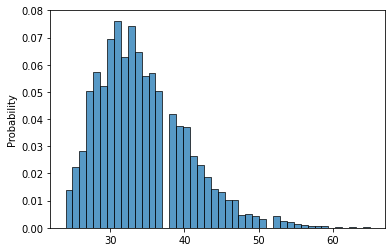

In [ ]:
import seaborn as sns
sns.histplot(sample_dtmc, stat='probability')

<AxesSubplot:ylabel='Probability'>

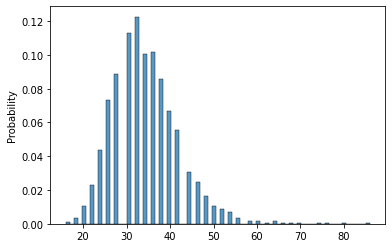

In [ ]:
sns.histplot(sample_cvar, stat='probability')

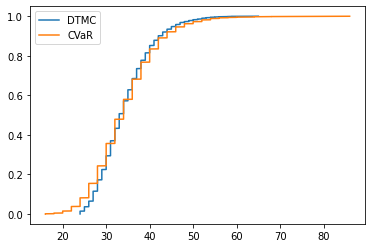

In [ ]:
x1 = np.sort(sample_dtmc)
x2 = np.sort(sample_cvar)
y = 1. * np.arange(len(sample_dtmc)) / (len(sample_dtmc) - 1)

#plot CDF

plt.plot(x1, y, label='DTMC')
plt.plot(x2, y, label='CVaR')
plt.legend()
plt.show()

In [ ]:
distr

In [ ]:
arr = np.array([0.000, 0.500, 0.250, 0.125, 0.062, 0.031, 0.016, 0.008, 0.004, 0.002, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000])

In [ ]:
z = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0])

In [ ]:
arr = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17022753571453167, 0.31891492215823797, 0.1567626480513812, 0.05118216018499157, 0.013643989313244502, 0.0032351774801199894, 7.130268323753448E-4, 1.4984610011878512E-4, 3.0513044244107402E-5, 2.4603800653719168E-5, 0.001396588456150835, 0.042334917847358385, 0.09208631431008223, 0.05761650606557643, 0.04320529099424163, 0.02221523535712152, 0.01640335150815666, 0.00696340710405944, 0.002162493290883658, 5.632152543138403E-4, 1.318578710495575E-4, 2.884003657870519E-5, 6.031651041796671E-6, 1.5275734870121406E-6])

In [ ]:
len(arr)

31

(0.0, 0.6)

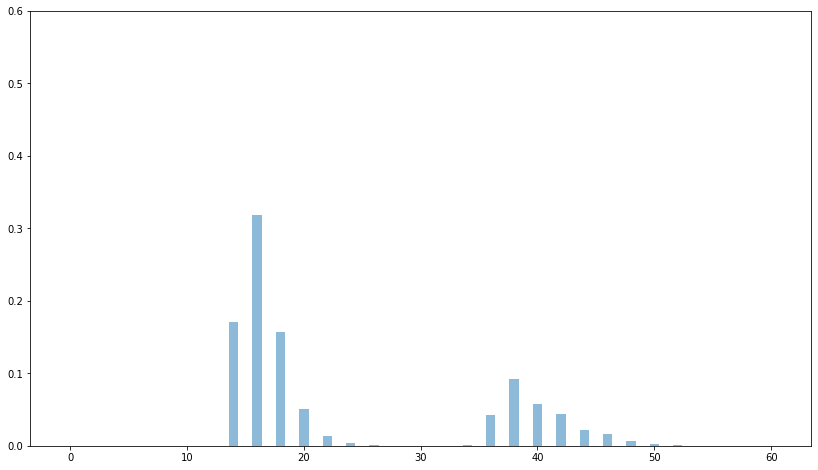

In [ ]:
plt.figure(figsize=(14,8))
plt.bar(z,arr[:31], alpha=0.5)
plt.ylim([0, 0.6])

In [ ]:
arr = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17022753571453167, 0.31891492215823797, 0.1567626480513812, 0.05118216018499157, 0.013643989313244502, 0.0032351774801199894, 7.130268323753448E-4, 1.4984610011878512E-4, 3.0513044244107402E-5, 2.4603800653719168E-5, 0.001396588456150835, 0.042334917847358385, 0.09208631431008223, 0.05761650606557643, 0.04320529099424163, 0.02221523535712152, 0.01640335150815666, 0.00696340710405944, 0.002162493290883658, 5.632152543138403E-4, 1.318578710495575E-4, 2.884003657870519E-5, 6.031651041796671E-6, 1.5275734870121406E-6])

In [ ]:
len(arr)

31

(0.0, 60.0)

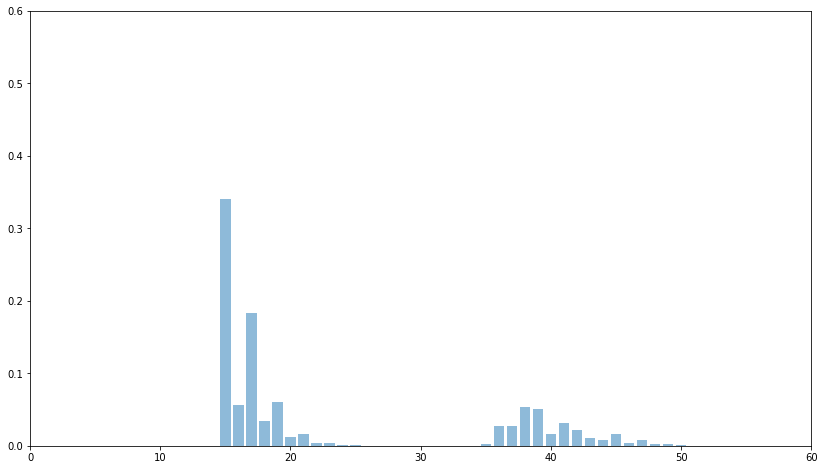

In [ ]:
plt.figure(figsize=(14,8))
plt.bar(z,arr, alpha=0.5)
plt.ylim([0, 0.6])
plt.xlim([0,60])

In [ ]:
arr2 = np.array([0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.341, 0.207, 0.228, 0.103, 0.068, 0.028, 0.014, 0.006, 0.003, 0.001, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000])

In [ ]:
arr2.shape

(201,)

(0.0, 130.0)

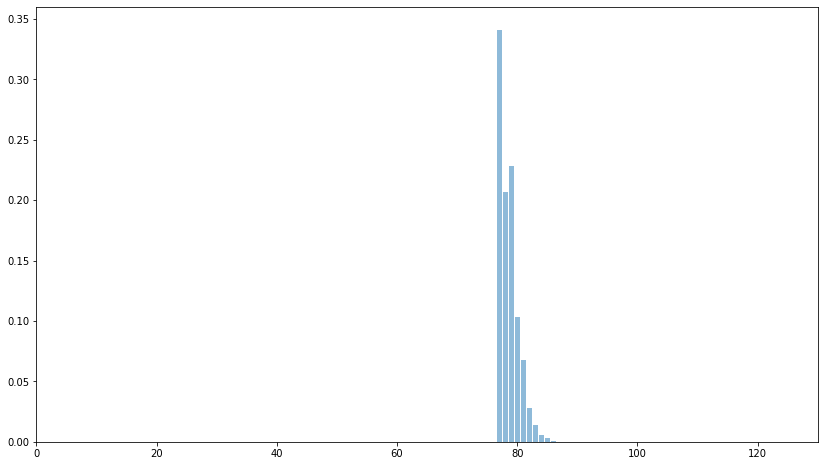

In [ ]:
plt.figure(figsize=(14,8))
plt.bar(np.arange(201),arr2, alpha=0.5)
plt.ylim([0, 0.36])
plt.xlim([0, 130])

In [ ]:
arr_qr = np.array([37.000, 37.000, 37.000, 37.000, 37.000, 37.000, 39.000, 39.000, 39.000, 39.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 41.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 42.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 43.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 44.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 45.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 46.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 47.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 48.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 49.000, 50.000, 50.000, 50.000, 50.000, 50.000, 50.000, 50.000, 50.000, 50.000, 50.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 51.000, 52.000, 52.000, 52.000, 52.000, 52.000, 52.000, 53.000, 53.000, 53.000, 53.000, 53.000, 53.000, 53.000, 53.000, 53.000, 54.000, 54.000, 55.000, 55.000, 55.000, 55.000, 56.000, 57.000, 57.000, 59.000, 59.000, 59.000, 60.000, 61.000, 61.000, 61.000, 61.000, 61.000, 61.000, 61.000, 62.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 63.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 65.000, 67.000, 67.000, 67.000, 67.000, 67.000, 67.000, 67.000, 67.000, 68.000, 69.000, 69.000, 69.000, 69.000, 70.000, 70.000, 71.000, 71.000, 71.000, 71.000, 73.000, 73.000, 79.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 81.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 82.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 83.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 84.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 85.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 86.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 87.000, 88.000, 88.000, 88.000, 88.000, 88.000, 88.000, 88.000, 88.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 89.000, 90.000, 90.000, 90.000, 91.000, 91.000, 91.000, 91.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 92.000, 93.000, 93.000, 94.000, 94.000, 94.000, 94.000, 94.000, 94.000, 94.000, 94.000, 94.000, 94.000, 95.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 96.000, 97.000, 97.000, 98.000, 98.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 99.000, 100.000, 100.000, 100.000, 100.000, 100.000, 100.000, 100.000, 100.000, 101.000, 101.000, 101.000, 101.000, 101.000, 101.000, 101.000, 101.000, 101.000, 102.000, 102.000, 102.000, 102.000, 102.000, 102.000, 102.000, 103.000, 103.000, 103.000, 103.000, 103.000, 103.000, 103.000, 103.000, 104.000, 104.000, 104.000, 104.000, 104.000, 104.000, 104.000, 104.000, 104.000, 104.000, 105.000, 105.000, 105.000, 105.000, 105.000, 105.000, 105.000, 105.000, 106.000, 106.000, 106.000, 106.000, 106.000, 106.000, 107.000, 107.000, 107.000, 107.000, 107.000, 107.000, 107.000, 107.000, 107.000, 108.000, 108.000, 108.000, 109.000, 109.000, 109.000, 109.000, 109.000, 110.000, 111.000, 111.000, 111.000, 111.000, 111.000])

In [ ]:
atoms = 1000
delta_p = 1.0/atoms
arr_conv = np.zeros(201)

for j in np.arange(atoms):
    val = arr_qr[j]
    low = math.floor(val)
    upp = math.ceil(val)
    if low - upp != 0:
        arr_conv[low] += (val - low) * delta_p
        arr_conv[upp] += (upp - val) * delta_p
    else:
        arr_conv[low] += delta_p
    
arr_conv

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.006, 0.   , 0.004, 0.   , 0.082, 0.014, 0.14 , 0.023,
       0.131, 0.021, 0.084, 0.017, 0.043, 0.01 , 0.016, 0.006, 0.009,
       0.002, 0.004, 0.001, 0.002, 0.   , 0.003, 0.001, 0.007, 0.001,
       0.012, 0.   , 0.013, 0.   , 0.008, 0.001, 0.004, 0.002, 0.004,
       0.   , 0.002, 0.   , 0.   , 0.   , 0.   , 0.   , 0.001, 0.   ,
       0.019, 0.024, 0.027, 0.028, 0.028, 0.014, 0.023, 0.008, 0.013,
       0.003, 0.004, 0.013, 0.002, 0.01 , 0.001, 0.012, 0.002, 0.002,
       0.014, 0.008, 0.009, 0.007, 0.008, 0.01 , 0.008, 0.006, 0.009,
       0.003, 0.005, 0.001, 0.005, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   ,